In [4]:
% matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import pickle

import keras
import matplotlib.image as mpimg
import matplotlib.patches as matplotlib_patches
import matplotlib.pyplot as plt
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, RepeatVector
from keras.models import Model
from keras.callbacks import TensorBoard


from functions_v1 import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

In [5]:
n = 5  # number of image to load

# Loaded a set of images
root_dir = "datas/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
files.sort()
n = min(n, len(files))  # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " groundtruth")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 5 images
satImage_001.png
Loading 5 groundtruth
satImage_001.png


## Data Exploration

Image size = 400,400


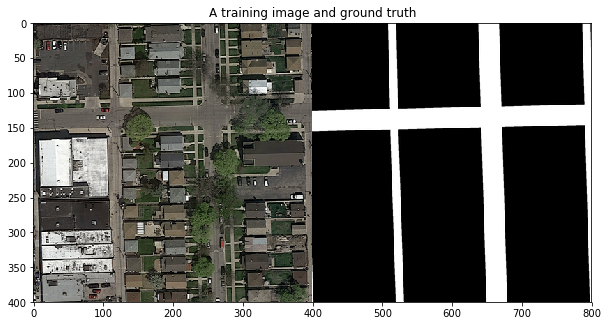

In [6]:
image = imgs[3]
gt_image = gt_imgs[3]
print('Image size = ' + str(image.shape[0]) + ',' + str(image.shape[1]))
fig1 = plt.figure(figsize=(10, 10))
plt.title("A training image and ground truth")
plt.imshow(concatenate_images(image, gt_image), cmap='Greys_r');


We observe that the road we need to label can be a difficult task. The variety of colors and obstacles is high : 
- Trees
- Cars
- Asphalt color

There are 625 patches of 16*16 for the image


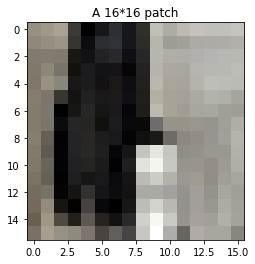

In [7]:
patch_size = 16
img_patches = get_patches(image, patch_size, patch_size, 0)
plt.title('A 16*16 patch')

print("There are", len(img_patches), "patches of 16*16 for the image")
plt.imshow(img_patches[5], cmap='Greys_r');


Our task is to label each of these 16\*16 patch.  
On the example above can be either some obstacle, a car, or an element of a roof.


However, this small size of portion of the image can miss some context. We need to expand this by adding some padding around it. 


## Padding

Instead of taking the raw 16\*16 patch, we can take a larger patch (padded patch) and then classify the 16\*16 center of that expanded patch.

In order to do that on the border of the image, we have to expand it. One of the way to do that is to mirroring the image

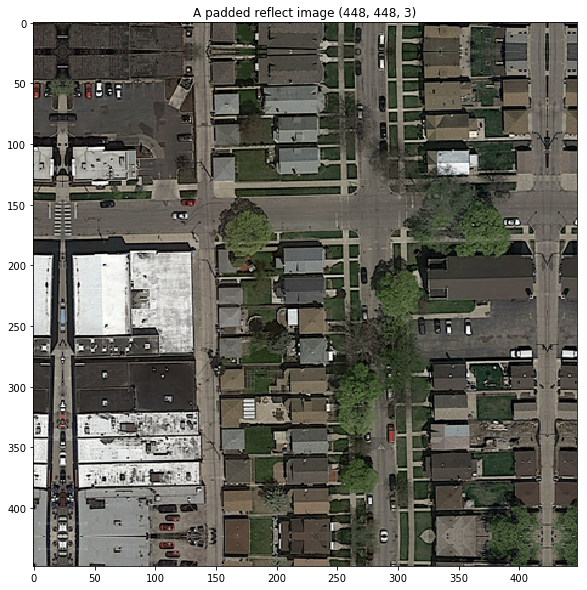

In [8]:
image = imgs[3]
gt_image = gt_imgs[3]

padding = 24
padded_patch_size = patch_size + padding * 2

padded_image = pad_image(image, padding)

fig1 = plt.figure(figsize=(10, 10))
plt.title("A padded reflect image " + str(padded_image.shape))
plt.imshow(padded_image, cmap='Greys_r');


There are 625 patches of 64*64 for the image


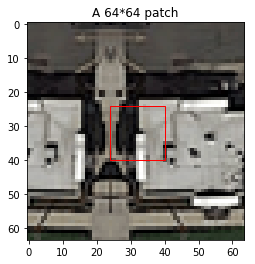

In [9]:
padded_img_patches = get_patches(padded_image, patch_size, patch_size, padding)

print("There are", len(padded_img_patches),
      'patches of ' + str(padded_patch_size) + '*' + str(padded_patch_size) + ' for the image')

fig, ax = plt.subplots(1)
plt.title('A ' + str(padded_patch_size) + '*' + str(padded_patch_size) + ' patch')

plt.imshow(padded_img_patches[5], cmap='Greys_r');
rect = matplotlib_patches.Rectangle((padding, padding), patch_size, patch_size, linewidth=1, edgecolor='r',
                                    facecolor='none')
ax.add_patch(rect)
plt.show()


Now we can see clearly that the center (the image inside the red square)of this padded image is not a road.

## Data augmentation
The dataset contains only 100 examples.
In order to increase the dataset, we can do the following transformation : 
- 90 degree rotation
- Horizontal flip
- Vertical flip

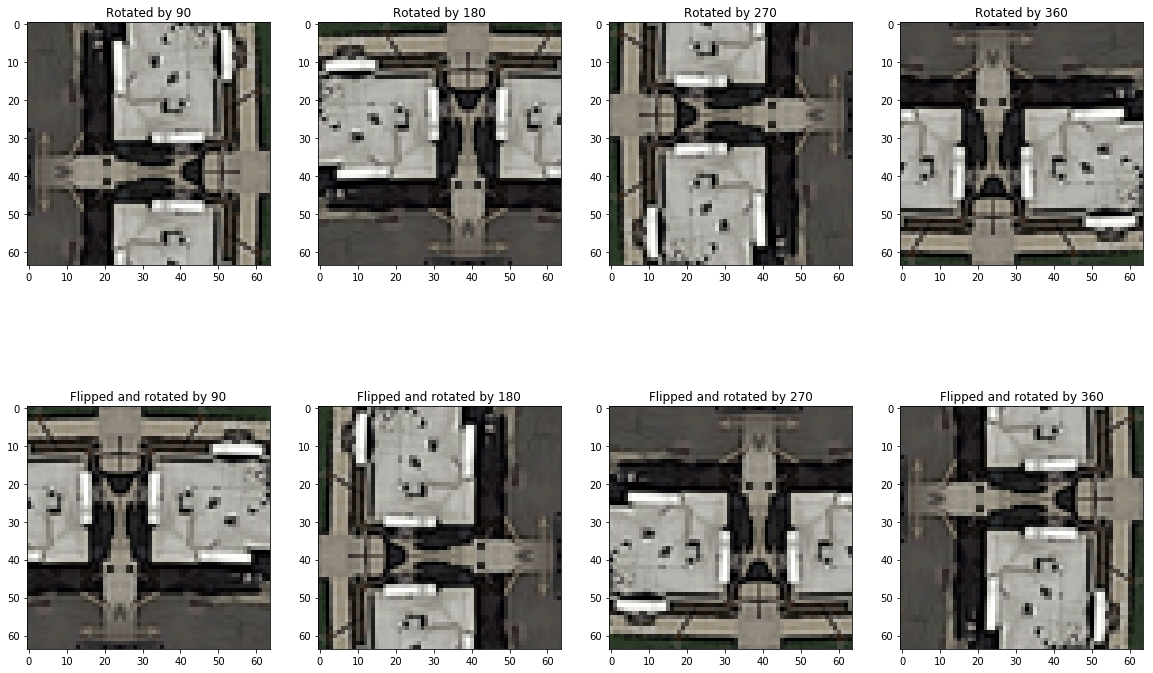

In [10]:
image_to_transform = padded_img_patches[5]
transformed_images = [np.rot90(image_to_transform, i + 1) for i in range(4)]

for i in range(4):
    transformed_images.append(np.rot90(np.flip(image_to_transform, 0), i))

plt.figure(figsize=(20, 20))
columns = 4
for i, transformed_image in enumerate(transformed_images):
    plt.subplot(len(transformed_images) / columns + 1, columns, i + 1)

    if i < 4:
        plt.title('Rotated by ' + str((i + 1) * 90))
    else:
        plt.title('Flipped and rotated by ' + str((i - 3) * 90))

    plt.imshow(transformed_image)


## X and Y
We create our training set.
- X : array of list of all patches
- Y : array of corresponding label

In [11]:
padded_images = pad_list_image(imgs, padding)
patches = [get_patches(image, patch_size, patch_size, padding) for image in padded_images]
patches = [patch for image_patches in patches for patch in
           image_patches]  # Flatten the array of patches to array of patch

gt_patches = [get_patches(gt_image, patch_size, patch_size, 0) for gt_image in gt_imgs]
gt_patches = [patch for image_patches in gt_patches for patch in image_patches]  # Flatten (same thing)

print("There are", len(gt_patches), "patches")


There are 3125 patches


We display an example to ensure our X and Y creation is correct

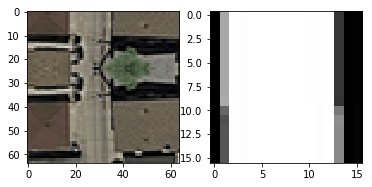

In [12]:
patch_size = 16
gt_img_patches = get_patches(gt_image, patch_size, patch_size, 0)

patch_index = 525

plt.subplot(1, 2, 1)
plt.imshow(patches[patch_index], cmap='Greys_r')

plt.subplot(1, 2, 2)
plt.imshow(gt_patches[patch_index], cmap='Greys_r');


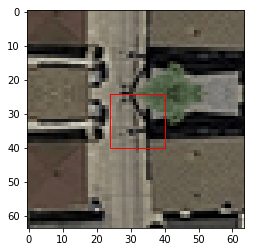

In [13]:
fig, ax = plt.subplots(1)
ax.imshow(patches[patch_index])
rect = matplotlib_patches.Rectangle((padding, padding), patch_size, patch_size, linewidth=1, edgecolor='r',
                                    facecolor='none')
ax.add_patch(rect)
plt.show()


We create our X and Y variable. The Y is created by transforming each grount truth patch image to a numeric integer (1=road or 0=none)

In [15]:
X = np.array(patches)
Y_labels = np.array(list(map(lambda x: patch_to_label(x), gt_patches)))


In [12]:
# Add rotation
# initial_count = len(X)
# for i in range(initial_count):
#     x = X[i]
#     y = Y[i]
#     X = np.concatenate((X, np.array([np.rot90(x, 1)]))) # 90 degree
#     X = np.concatenate((X, np.array([np.rot90(x, 2)]))) # 180 degree
#     Y = np.append(Y, y)
#     Y = np.append(Y, y)


In [20]:
Y_categorical = keras.utils.to_categorical(Y_labels, num_classes=2)


In [13]:
pickle.dump(X, open("pickle/X.pickle", "wb"))
pickle.dump(Y_labels, open("pickle/Y_labels.pickle", "wb"))
pickle.dump(Y_categorical, open("pickle/Y_categorical.pickle", "wb"))


## Building the convolutional neural network

In [16]:
input_shape = X[0].shape

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('elu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


###  Split train test set

In [21]:
x_train, x_test, y_train, y_test = train_test_split(X, Y_categorical, test_size=0.1, random_state=42)


###  Create Image data generator to get flips

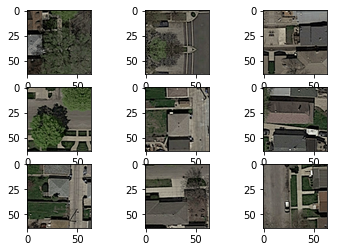

In [25]:
batch_size = 16

datagen = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
# datagen.fit(X)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
for X_batch, y_batch in train_generator:
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
    plt.show()
    break


###  Load existing weights

In [17]:
model.load_weights("./weights/model.h5")


###  Training

In [26]:
epochs = 1

# model.fit(x_train, y_train,
#               batch_size=batch_size,
#               epochs=epochs,
#               validation_data=(x_test, y_test),
#               shuffle=True)

model.fit_generator(train_generator,
                    epochs=epochs,
                    steps_per_epoch=3516,
                    shuffle=True)


Epoch 1/1
  55/3516 [..............................] - ETA: 6:05 - loss: 0.1425 - acc: 0.9545

KeyboardInterrupt: 

In [27]:
score = model.evaluate(x_test, y_test, batch_size)
print("Test accuracy:", score[1])


313/313 [==============================] - 1s 2ms/step
Test accuracy: 0.968051118211


###  Save weights

In [30]:
model.save_weights("./weights/model.h5")

###  Display a prediction vs ground truth

In [28]:
pred_img, gt_image = display_prediction_and_gt(model, X, Y_labels, 400, 16, 6)

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
predictions = model.predict_classes(X[:625 * 3])
save_labels_to_images(400, 400, patch_size, patch_size, predictions)


## Autoencoder

### Prepare the data

In [29]:
# 608/8 = 76
# 76 - 50 = 26
# 26/2 = 13
autoencoder_padding = 13

def get_autoencoder_XY(model, X, Y_labels, image_size, patch_size, autoencoder_padding, data_augmentation=False):
    pred_img_array = []
    gt_image_array = []
    patch_count_per_image = int((image_size / patch_size) ** 2)
    for i in range(int(len(X) / patch_count_per_image)):
        pred_img, gt_image = display_prediction_and_gt(model, X, Y_labels, image_size, patch_size, i, display=False)

        pred_img = pred_img.reshape(image_size, image_size, 1)
        pred_img = pad_image(pred_img, autoencoder_padding)

        if Y_labels is not None:
            gt_image = gt_image.reshape(image_size, image_size, 1)
            gt_image = pad_image(gt_image, autoencoder_padding)

        if data_augmentation:
            for j in range(4):
                pred_img_array.append(np.rot90(np.flip(pred_img, 0), j))
                pred_img_array.append(np.rot90(pred_img, j + 1))

            if Y_labels is not None:
                for j in range(4):
                    gt_image_array.append(np.rot90(np.flip(gt_image, 0), j))
                    gt_image_array.append(np.rot90(gt_image, j + 1))
        else:
            pred_img_array.append(pred_img)
            
            if Y_labels is not None:
                gt_image_array.append(gt_image)

    pred_img_array = np.array(pred_img_array)
    
    if Y_labels is not None:
        gt_image_array = np.array(gt_image_array)
    else:
        gt_image_array = None
    
    return pred_img_array, gt_image_array
    
# Output size 76*76
pred_img_array, gt_image_array = get_autoencoder_XY(model, X, Y_labels, 50, 2, autoencoder_padding, data_augmentation=True)

### Build the autoencoder model

In [30]:
input_img = Input(shape=pred_img_array[0].shape)  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Dropout(0.2)(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [31]:
autoencoder.load_weights("./weights/autoencoder.h5")


### Training

In [22]:
x_train_encoder, x_test_encoder, y_train_encoder, y_test_encoder = train_test_split(pred_img_array, gt_image_array, test_size=0.1, random_state=42)

In [59]:
autoencoder.fit(x_train_encoder, y_train_encoder,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test_encoder, y_test_encoder),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])



Train on 720 samples, validate on 80 samples
Epoch 1/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1353 - val_loss: 0.1511
Epoch 2/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1349 - val_loss: 0.1507
Epoch 3/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1349 - val_loss: 0.1508
Epoch 4/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1348 - val_loss: 0.1523
Epoch 5/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1341 - val_loss: 0.1507
Epoch 6/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1349 - val_loss: 0.1499
Epoch 7/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1346 - val_loss: 0.1501
Epoch 8/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1348 - val_loss: 0.1499
Epoch 9/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1342 - val_loss: 0.1515
Epoch 10/100
720/720 [========================

Epoch 81/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1281 - val_loss: 0.1529
Epoch 82/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1278 - val_loss: 0.1485
Epoch 83/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1276 - val_loss: 0.1486
Epoch 84/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1276 - val_loss: 0.1477
Epoch 85/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1275 - val_loss: 0.1467
Epoch 86/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1273 - val_loss: 0.1483
Epoch 87/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1275 - val_loss: 0.1469
Epoch 88/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1275 - val_loss: 0.1469
Epoch 89/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1272 - val_loss: 0.1482
Epoch 90/100
720/720 [==============================] - 1s 2ms/step - loss: 0.1274

In [23]:
score = autoencoder.evaluate(x_test_encoder, y_test_encoder, 1)
print("Test loss", score)

80/80 [==============================] - 0s 3ms/step
Test loss 0.149557662406


In [61]:
autoencoder.save_weights("./weights/autoencoder.h5")

### Predict

NameError: name 'x_test_encoder' is not defined

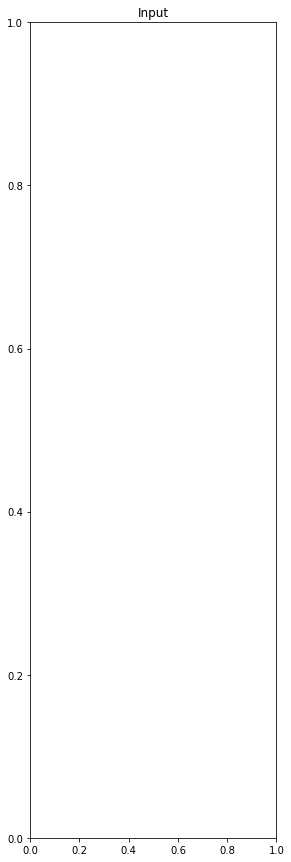

In [33]:
index = 0

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title('Input')
plt.imshow(x_test_encoder[index].reshape((76,76)), cmap='Greys_r')
plt.subplot(1, 3, 2)
plt.title('Ouput')
decoded_imgs = autoencoder.predict(np.array([x_test_encoder[index]]))
plt.imshow(decoded_imgs[0].reshape((76,76)), cmap='Greys_r');
plt.subplot(1, 3, 3)
plt.title('Groundtruth')
plt.imshow(y_test_encoder[index].reshape((76,76)), cmap='Greys_r');

## Test data

In [34]:
# Free some memory
del predictions
del padded_images
del patches
del X
del Y

NameError: name 'predictions' is not defined

In [35]:
TEST_IMG_SIZE = 608

In [36]:
test_dir = "datas/test_set_images/"
files = os.listdir(test_dir)
n = min(100, len(files))  # Load maximum 20 images
files.sort()
print("Loading " + str(n) + " images")
test_imgs = [load_image(test_dir + files[i] + '/' + os.listdir(test_dir + files[i])[0]) for i in range(n)]
print("Loaded !")


Loading 50 images
Loaded !


In [37]:
test_padded_images = pad_list_image(test_imgs, padding)
test_patches = [get_patches(image, patch_size, patch_size, padding) for image in test_padded_images]
test_patches = [patch for image_patches in test_patches for patch in
                image_patches]  # Flatten the array of patches to array of patch

test_X = np.array(test_patches)


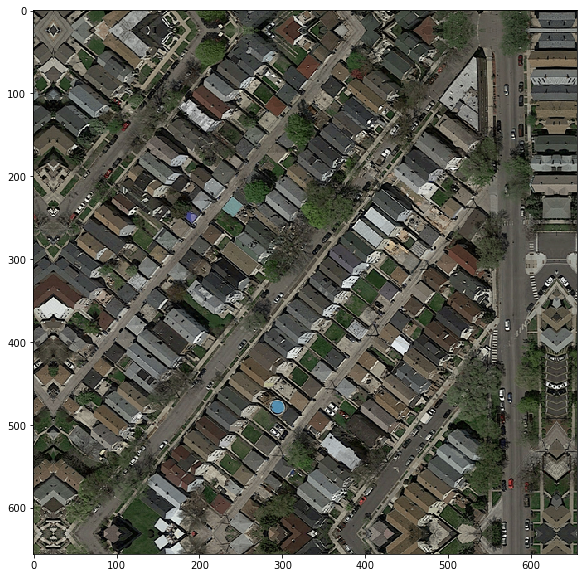

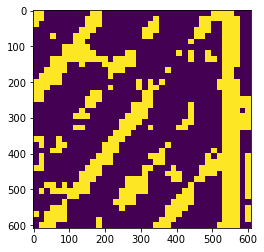

In [38]:
plt.figure(figsize=(10, 10))
plt.imshow(test_padded_images[len(test_padded_images) - 1]);
plt.show()
test_label = label_to_img(TEST_IMG_SIZE, TEST_IMG_SIZE, patch_size, patch_size, model.predict_classes(test_X[-1444:]))
plt.imshow(test_label);


In [36]:
predictions = model.predict_classes(test_X)
save_labels_to_images(TEST_IMG_SIZE, TEST_IMG_SIZE, patch_size, patch_size, predictions)


Saving predictions/prediction_1.png
Saving predictions/prediction_2.png
Saving predictions/prediction_3.png
Saving predictions/prediction_4.png
Saving predictions/prediction_5.png
Saving predictions/prediction_6.png
Saving predictions/prediction_7.png
Saving predictions/prediction_8.png
Saving predictions/prediction_9.png
Saving predictions/prediction_10.png
Saving predictions/prediction_11.png
Saving predictions/prediction_12.png
Saving predictions/prediction_13.png
Saving predictions/prediction_14.png
Saving predictions/prediction_15.png
Saving predictions/prediction_16.png
Saving predictions/prediction_17.png
Saving predictions/prediction_18.png
Saving predictions/prediction_19.png
Saving predictions/prediction_20.png
Saving predictions/prediction_21.png
Saving predictions/prediction_22.png
Saving predictions/prediction_23.png
Saving predictions/prediction_24.png
Saving predictions/prediction_25.png
Saving predictions/prediction_26.png
Saving predictions/prediction_27.png
Saving pre

## Test data using autoencoder

In [95]:
test_X_autoencoder, _ = get_autoencoder_XY(model, test_X, None, 76, 2, 0)

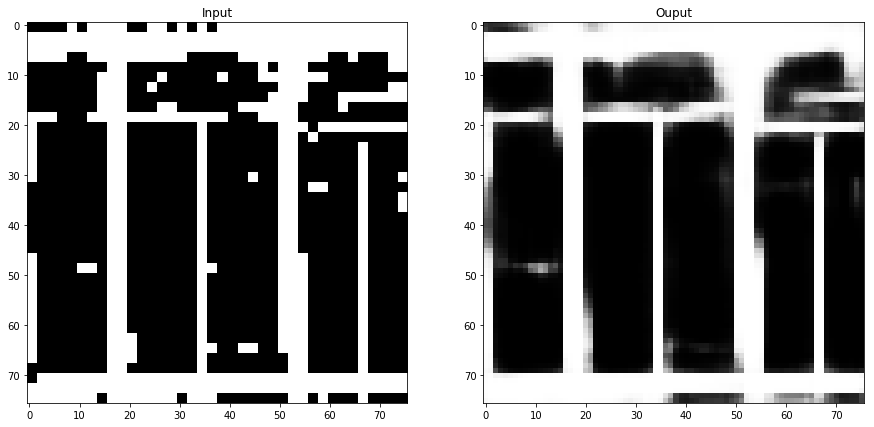

In [71]:
index = 0

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title('Input')
plt.imshow(test_X_autoencoder[index].reshape((76,76)), cmap='Greys_r')
plt.subplot(1, 2, 2)
plt.title('Ouput')
decoded_imgs = autoencoder.predict(np.array([test_X_autoencoder[index]]))
plt.imshow(decoded_imgs[0].reshape((76,76)), cmap='Greys_r');

In [97]:
# Enlarge image and save it
for i in range(50):
    decoded_img = autoencoder.predict(np.array([test_X_autoencoder[i]]))[0]
    enlarged_image = scipy.misc.imresize(decoded_img.reshape((76,76)), size=(608, 608))
    prediction_test_dir = "predictions/"

    im = Image.fromarray(img_float_to_uint8(enlarged_image))
    print("Saving " + prediction_test_dir + "prediction_" + str(i + 1) + ".png")

    im.save(prediction_test_dir + "prediction_" + str(i + 1) + ".png")


Saving predictions/prediction_1.png
Saving predictions/prediction_2.png
Saving predictions/prediction_3.png
Saving predictions/prediction_4.png
Saving predictions/prediction_5.png
Saving predictions/prediction_6.png
Saving predictions/prediction_7.png
Saving predictions/prediction_8.png
Saving predictions/prediction_9.png
Saving predictions/prediction_10.png
Saving predictions/prediction_11.png
Saving predictions/prediction_12.png
Saving predictions/prediction_13.png
Saving predictions/prediction_14.png
Saving predictions/prediction_15.png
Saving predictions/prediction_16.png
Saving predictions/prediction_17.png
Saving predictions/prediction_18.png
Saving predictions/prediction_19.png
Saving predictions/prediction_20.png
Saving predictions/prediction_21.png
Saving predictions/prediction_22.png
Saving predictions/prediction_23.png
Saving predictions/prediction_24.png
Saving predictions/prediction_25.png
Saving predictions/prediction_26.png
Saving predictions/prediction_27.png
Saving pre